# Spatial Distribution

In [15]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from multiprocessing import Pool
import yaml

In [2]:
from auriga.snapshot import Snapshot
from auriga.images import figure_setup
from auriga.settings import Settings
from auriga.parser import parse

In [11]:
figure_setup()
settings = Settings()

In [16]:
CONFIG_FILE: str = "02"
CONFIG = yaml.safe_load(open(f"../configs/{CONFIG_FILE}.yml"))

In [28]:
SIMULATION = "au6_or_l4_s127"
SIMULATIONS = [f"au{i}_or_l4_s127" for i in settings.groups["Included"]]

In [ ]:
def read_data(simulation: str, config: dict) -> pd.DataFrame:
    s = Snapshot(simulation=simulation, loadonlytype=[0, 1, 2, 3, 4, 5])
    s.add_stellar_age()
    s.tag_particles_by_region(
        disc_std_circ=config["DISC_STD_CIRC"],
        disc_min_circ=config["DISC_MIN_CIRC"],
        cold_disc_delta_circ=config["COLD_DISC_DELTA_CIRC"],
        bulge_max_specific_energy=config["BULGE_MAX_SPECIFIC_ENERGY"])

    is_real_star = (s.type == 4) & (s.stellar_formation_time > 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)
    mask = is_main_obj & is_real_star

    props = {
        "CylindricalRadius_ckpc": s.rho[mask],
        "xPosition": s.pos[mask, 0],
        "yPosition": s.pos[mask, 1],
        "zPosition": s.pos[mask, 2],
        "ComponentTag": s.region_tag[mask],
        "StellarAge_Gyr": s.stellar_age[mask]}

    df = pd.DataFrame(props)
    df[~np.isfinite(df)] = np.nan
    df.dropna(inplace=True)
    return df

In [59]:
def get_mask(df: pd.DataFrame,
             component: str = None,
             age_range: tuple = (0.0, 14.0)) -> pd.Series:
    settings = Settings()
    is_age = (df["StellarAge_Gyr"] >= age_range[0]) \
        & (df["StellarAge_Gyr"] <= age_range[1])
    is_component = np.ones(is_age.shape, dtype="bool")
    if component is not None:
        is_component = df["ComponentTag"] == settings.component_tags[component]
    mask = is_age & is_component 
    return mask

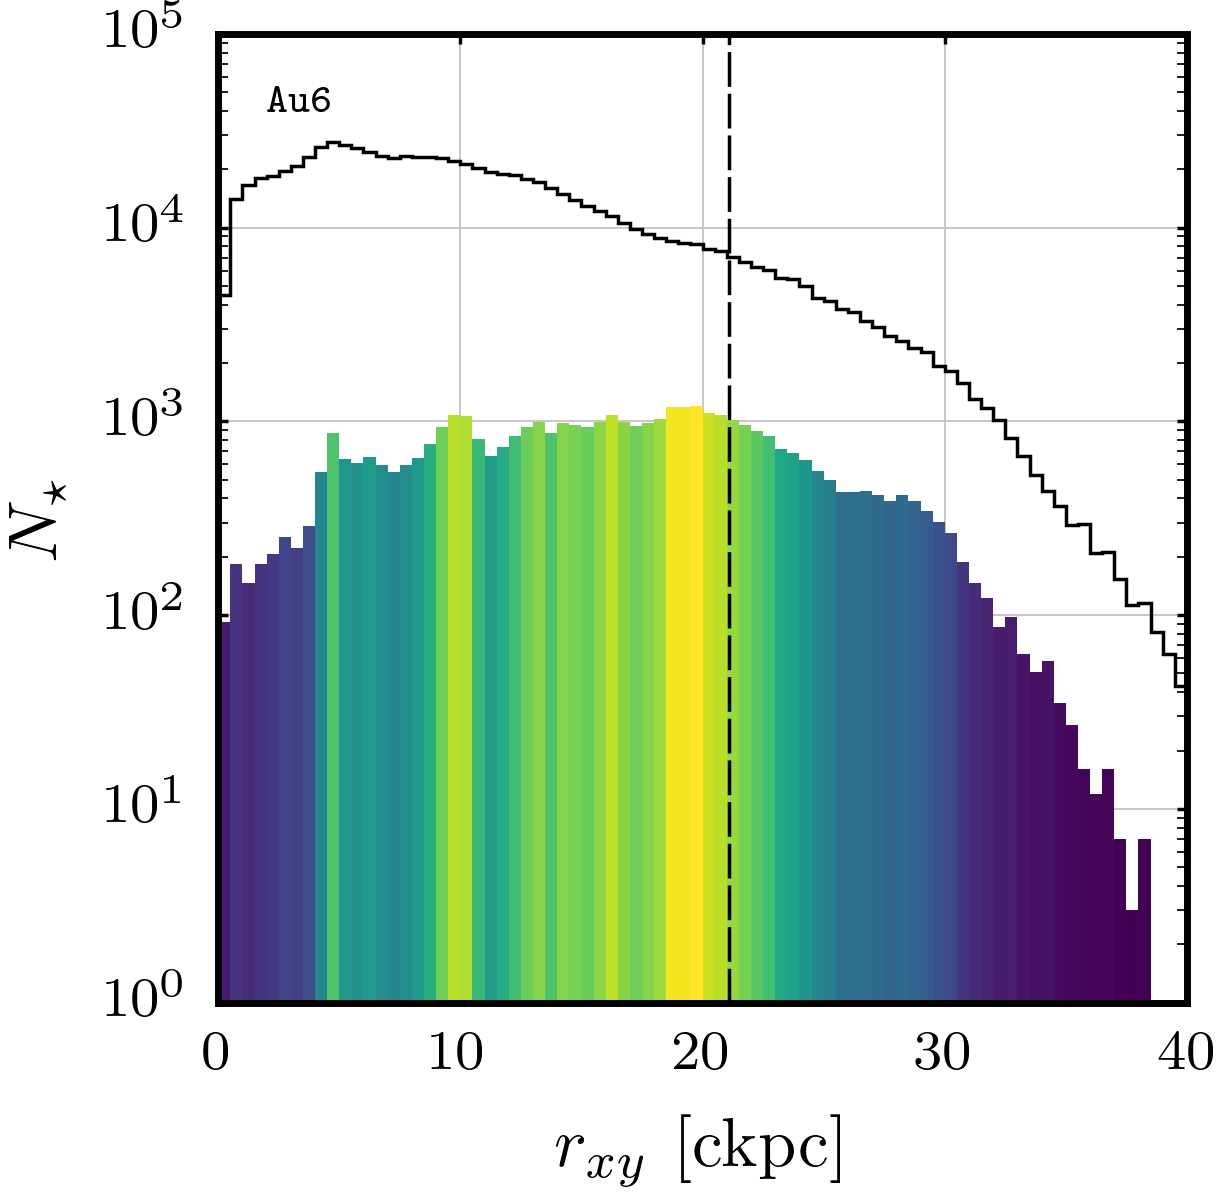

In [60]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.tick_params(which='both', direction="in")
ax.set_axisbelow(True)
ax.grid(True, ls='-', lw=0.25, c='silver')

ax.set_xlim(0, 40)
ax.set_xticks([0, 10, 20, 30, 40])
ax.set_xlabel(r"$r_{xy}$ [ckpc]")

ax.set_ylim(1E0, 1E5)
ax.set_yticks([1E0, 1E1, 1E2, 1E3, 1E4])
ax.set_ylabel(r"$N_\star$")
ax.set_yscale("log")

galaxy = parse(SIMULATION)[0]
label = f"Au{galaxy}"
df = read_data(simulation=SIMULATION, config=CONFIG)

mask = get_mask(df, component="CD", age_range=(0.0, 1.0))
N, bins, patches = ax.hist(df["CylindricalRadius_ckpc"][mask],
                           bins=100, range=[0.0, 50.0], linewidth=0.0)
fracs = N / N.max()
norm = mcolors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

# region Reference Histogram
mask = get_mask(df, component="CD")
ax.hist(df["CylindricalRadius_ckpc"][mask],
        bins=100, range=[0.0, 50.0], histtype="step", color="black", lw=0.5)
# endregion

# region Disc Radius Indication
gal_data = pd.read_csv("../data/iza_2022.csv")
disc_radius = gal_data["DiscRadius_kpc"][gal_data["Galaxy"] == galaxy]
disc_radius = disc_radius.values[0]
ax.plot([disc_radius] * 2, ax.get_ylim(), ls=(0, (5, 1)), c='k', lw=0.5)
# endregion

ax.text(x=0.05, y=0.95, s=r"$\texttt{" + label + "}$",
        size=6.0, transform=ax.transAxes, ha='left', va='top')

plt.show()

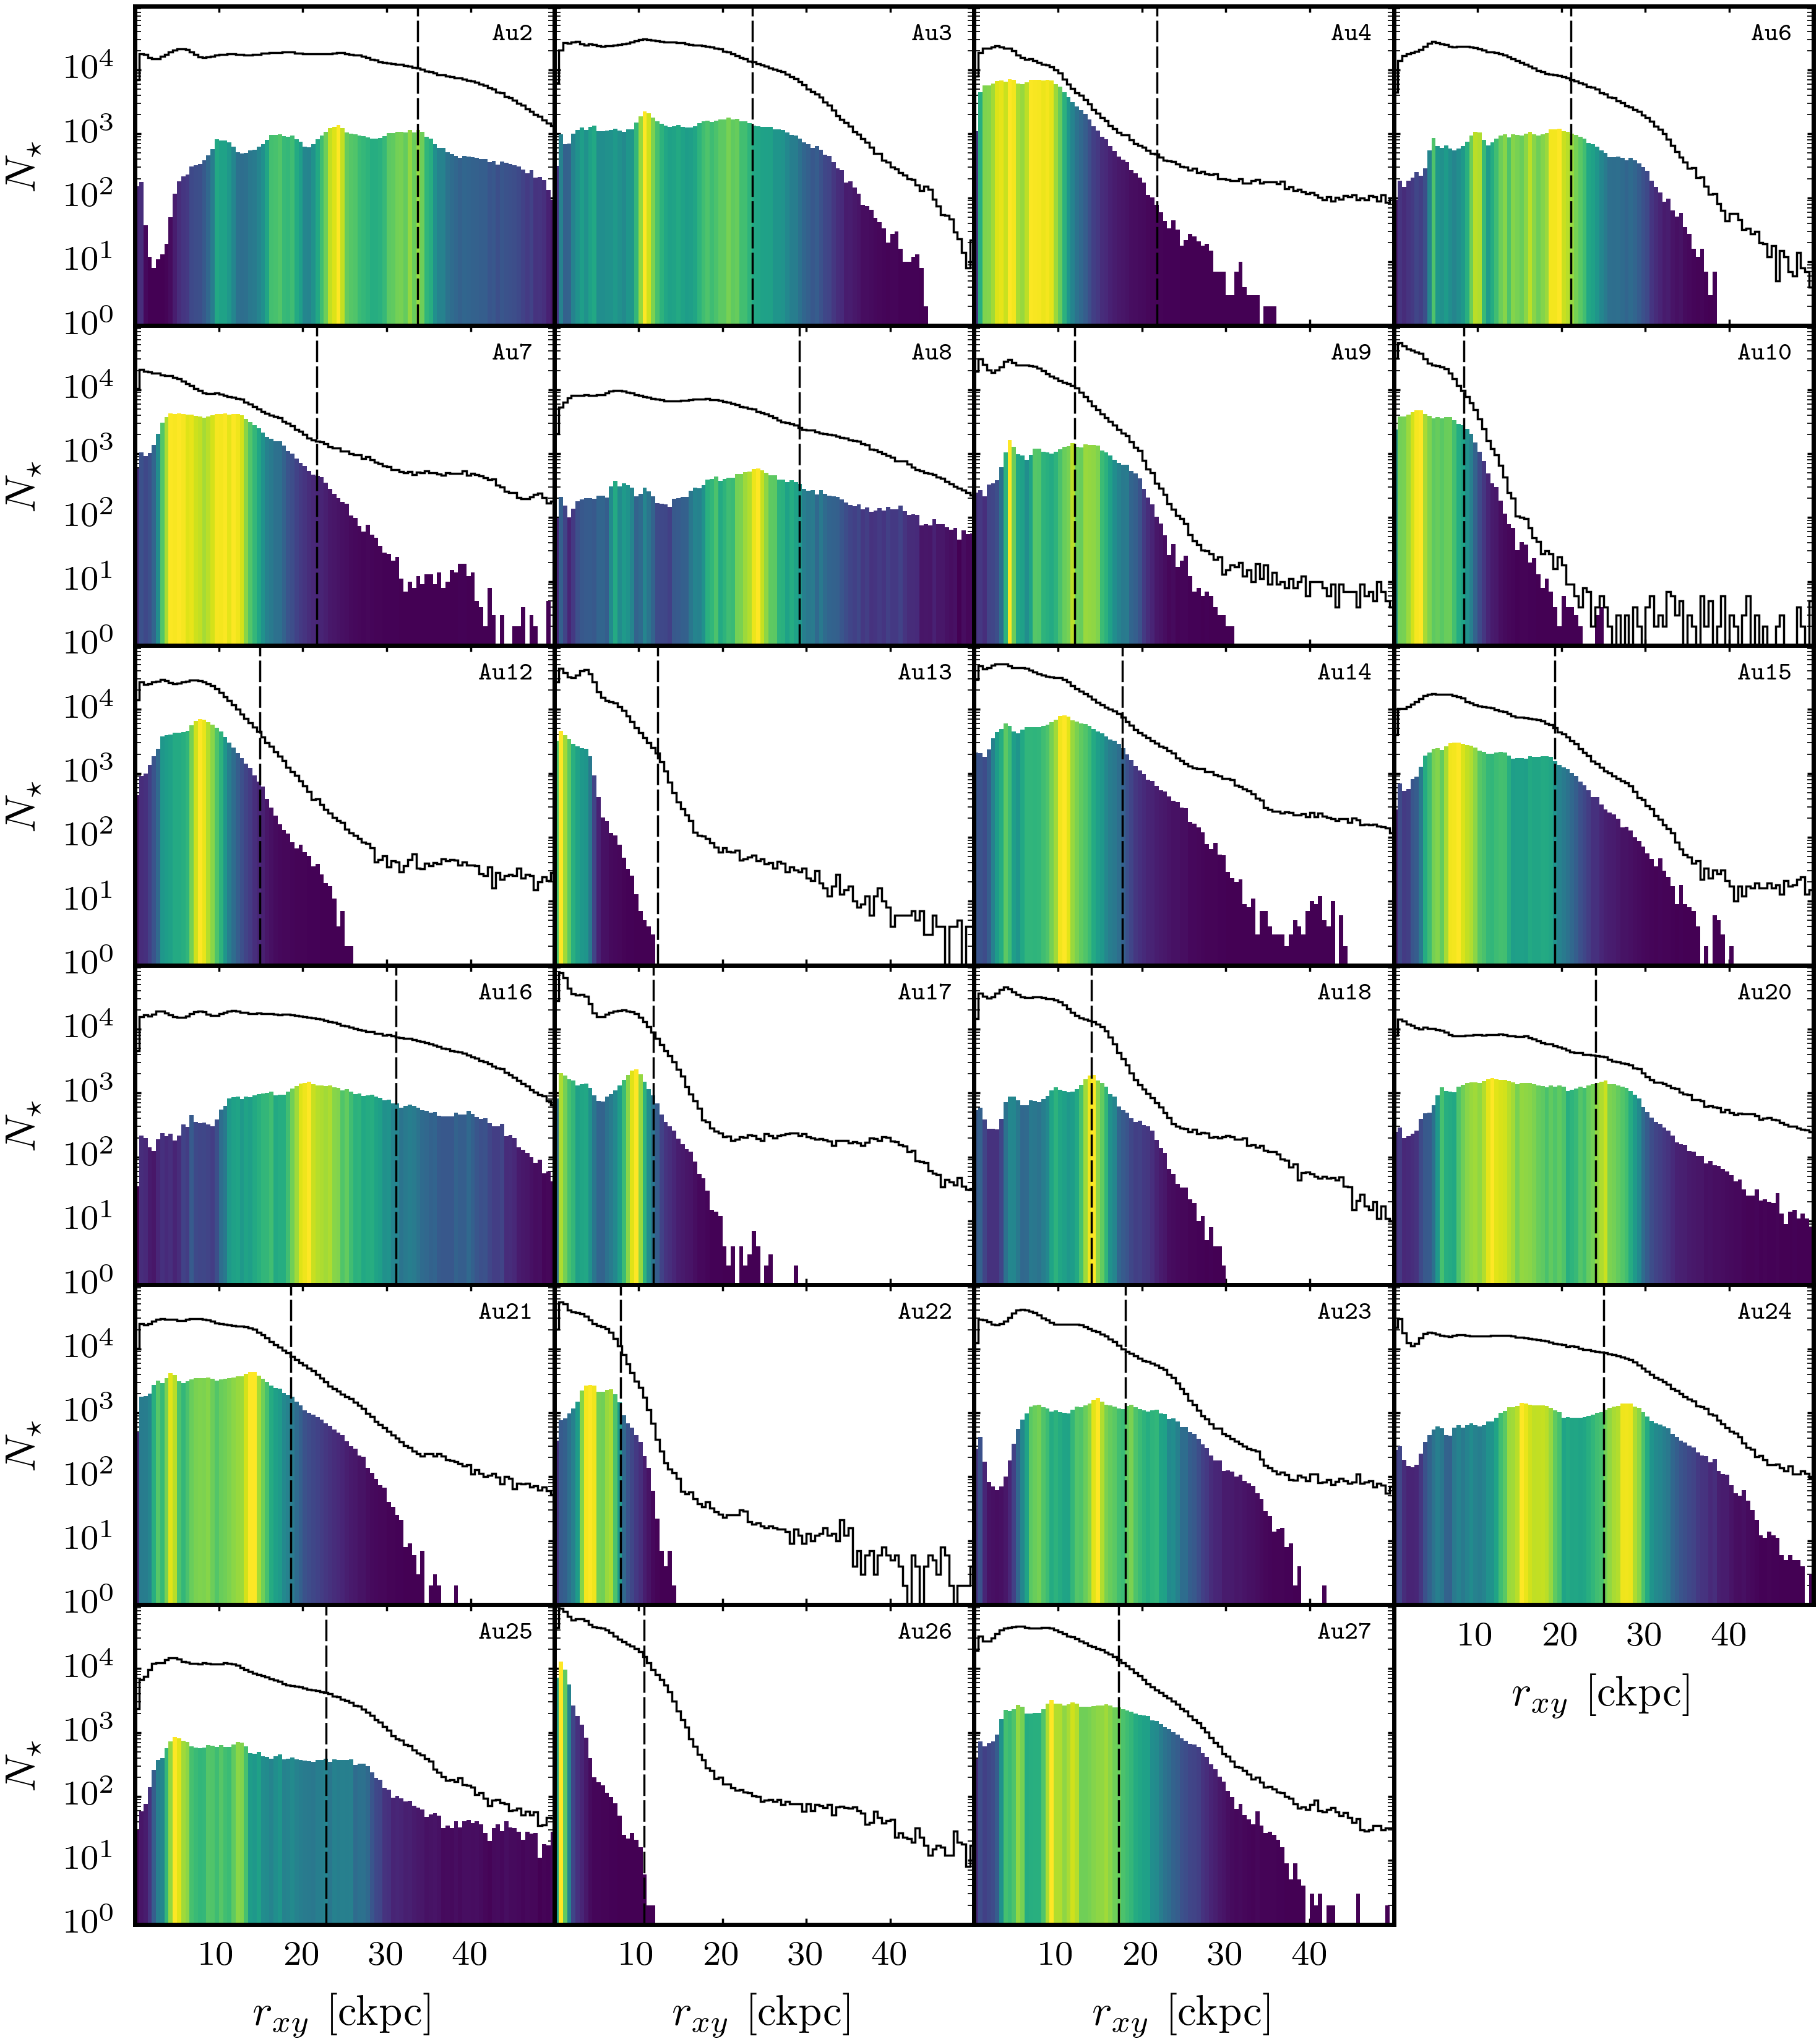

In [62]:
fig = plt.figure(figsize=(7, 8))
gs = fig.add_gridspec(nrows=6, ncols=4, hspace=0.0, wspace=0.0)
axs = gs.subplots(sharex=True, sharey=True)

for ax in axs.flatten():
    ax.tick_params(which='both', direction="in")
    if ax == axs[-1, -1]: ax.axis("off")
    ax.set_xlim(0, 50)
    ax.set_xticks([10, 20, 30, 40])
    ax.set_yscale("log")
    ax.set_ylim(1E0, 1E5)
    ax.set_yticks([1E0, 1E1, 1E2, 1E3, 1E4])
    ax.set_axisbelow(True)
    if ax.get_subplotspec().is_last_row() or ax == axs[-2, -1]:
        ax.set_xlabel(r"$r_{xy}$ [ckpc]")
        ax.tick_params(labelbottom=True)
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel(r"$N_\star$")

for i, simulation in enumerate(SIMULATIONS):
    ax = axs.flatten()[i]
    galaxy = parse(simulation)[0]
    label = f"Au{galaxy}"
    df = read_data(simulation=simulation, config=CONFIG)

    mask = get_mask(df, component="CD", age_range=(0.0, 1.0))
    N, bins, patches = ax.hist(df["CylindricalRadius_ckpc"][mask],
                            bins=100, range=(0, 50), linewidth=0.0)
    fracs = N / N.max()
    norm = mcolors.Normalize(fracs.min(), fracs.max())
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)

    mask = get_mask(df, component="CD")
    ax.hist(df["CylindricalRadius_ckpc"][mask],
        bins=100, range=(0, 50), histtype="step", color="black", lw=0.5)

    # region Disc Radius Indication
    gal_data = pd.read_csv("../data/iza_2022.csv")
    disc_radius = gal_data["DiscRadius_kpc"][gal_data["Galaxy"] == galaxy]
    disc_radius = disc_radius.values[0]
    ax.plot([disc_radius] * 2, ax.get_ylim(), ls=(0, (5, 1)), c='k', lw=0.5)
    # endregion

    ax.text(x=0.95, y=0.95, s=r"$\texttt{" + label + "}$",
            size=6.0, transform=ax.transAxes, ha='right', va='top')

plt.show()